# Solving PDE for ZcB under CIR model via Discretization

**Introduction:<br>**
Solving PDE for ZCB where the short rate follows a CIR SDE. 
<br>


**Author:** <br>
This Notebook (implementation and analysis) is the work and property of Joshua KAJI - FRM. All Rights reserved.


**Table of Content:**

1) PDE of interest rate instruments<br>
    1.1 PDE for derivative under RN measures with general short rate underlying <br>
    1.2 PDE for instrument with CIR underlying<br>
2) Solving PDE via discretization<br>
    2.1 Discretization of the Grid<br>
    2.2 Discretization of the partial derivatives<br>
    2.3 Discretization of PDE<br>
    2.4 Discretizing initial and boundary conditions <br>
    2.5 Solving the system of equations by recussion <br>
3) compare PDE vs Monte Carlo results<br>

## 1) PDE of interest rate instruments


### 1.1) PDE for derivative under RN measures with general short rate underlying 




Let the short-term interest rate $ r_t $ follow the stochastic differential equation (SDE):

$$
dr_t = a(t, r_t) \, dt + b(t, r_t) \, dW_t
$$

where:
- $a(t, r_t)$ is the drift term, 
- $b(t, r_t) $ is the volatility term,
- $ dW_t $ is a Wiener process 

The price $V(r_t, t)$ of a derivative under risk neutrale measure satisfies the following PDE:

$$
\frac{\partial V}{\partial t} + a(t, r_t) \frac{\partial V}{\partial r_t} + \frac{1}{2} b(t, r_t)^2 \frac{\partial^2 V}{\partial r_t^2} - r_t V = 0
$$

The boundary conditions depend on the specific derivative being priced.


### 1.2) PDE for instrument with CIR underlying

**<u>Cox-Ingersoll-Ross (CIR) Model</u>**

The Cox-Ingersoll-Ross (CIR) model is defined by the following stochastic differential equation (SDE):


$$
\begin{aligned}
dr_t = (a - b r_t) dt + \sigma \sqrt{r_t} dW_t
\end{aligned}
$$



**<u>PDE of a derivative under RN measure (CIR underlying):</u>**

The risk neutrale price of a derivative U(r, t) under the CIR model verifies the following PDE:

$$
\begin{aligned}
\frac{\partial U}{\partial t} + (a - b r) \frac{\partial U}{\partial r} + \frac{1}{2} \sigma^2 r \frac{\partial^2 U}{\partial r^2} - r V = 0
\end{aligned}
$$

**<u>PDE of a ZcB where short rate follows CIR:</u>**

Under risk neutrale pricing, a zero coupon bond with notional 1 maturing in T may be expressed in the following:
$$
P(t, T) = \mathbb{E}^{\mathbb{Q}} \left[ e^{-\int_t^T r_s \, ds} \, \Big| \,\mathcal{F}_t \right]
$$
we can reformulate the above to the notations of the PDE:
$$
U(x, t) = \mathbb{E}^{\mathbb{Q}} \left[ e^{-\int_t^T r_s \, ds} \Big|  \mathcal{r}_t =  x \right]
$$

<u>Note</u> : $t$ represents the current time. In the next part, we change the variable $t$ such that the option price is a function not of current time but of time to maturity remaining. 


**<u>Applying variable change :</u>**

We may express the the price of the instrument as a function of time to maturity by applying a variable change $t \rightarrow T - t$:

Let $V : x, t \rightarrow U(x, T-t)$

$$ 
V(x, \tau) =  \mathbb{E}^{\mathbb{Q}} \left[ e^{-\int_{T - t}^T r_s \, ds} \Big|  \mathcal{r}_{T - t} =  x\right] 
$$

where $t$ is the time to maturity remaining. Note that the function $V$ is still defined in $ t \in [0, T]$.

following this variable change, given that $d\tau = -dt$, $V$ verifies the following PDE:

$$
\begin{aligned}
-\frac{\partial V}{\partial t} + (a - b r) \frac{\partial V}{\partial r} + \frac{1}{2} \sigma^2 r \frac{\partial^2 V}{\partial r^2} - r V = 0
\end{aligned}
$$

where $t$ represent the time to maturity remaining of the ZCB.


## 2) Solving PDE via discretization



### 2.1) Discretization of the Grid

We discretize the time interval $[0, T]$ into $M$ time steps with time step size $\Delta t$, and the interest rate space into $N$ steps with spacing $\Delta r$. Thus, we have:
$$
\begin{align}
t_i &= i \Delta t \quad \text{for} \, i = 0, 1, \dots, M \\
r_j &= j \Delta r \quad \text{for} \, j = 0, 1, \dots, N 
\end{align}
$$

In the implementation, we take $T=30Y$ and $r \in [0, 2]$

In [17]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Oct  4 19:43:47 2024

@author: joshuakaji
"""

# CIR params such that dr = (a - br)dt + sig sqrt(r) dWt
b = 0.54958
a = 0.38757*b
sig = 0.001


# solving ZCB PDE for CIR model 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

####################################################
# discrtize r
r_min = 0
r_max = 2 #r = 100%
#dr = (r_max - r_min)/N
dr = 0.01
r_j = np.arange(r_min, r_max+dr, dr)
N = len(r_j)
j_L = np.arange(0, N, 1)
#r_j = [dr*j for j in j_L]
print(len(r_j) == N ==len(j_L))
# r_j[N] == r_max

####################################################
# discretize time t (t here is time to maturity of B(0, T=t))
t_max = 20
t_min = 0
dt = 1/252
t_i = np.arange(t_min, t_max+dt, dt)
M = len(t_i)   # might not be useful
i_L = np.arange(0, M, 1)
print(len(i_L) == len(t_i) == M)
# t_i[M] == t_max

True
True


### 2.2) Discretization of the partial derivatives

Let $V^i_j$ represent the value of $V(t_i, r_j)$.

<u>**Discretizing the Time Derivative**</u>

We approximate the time derivative using the <u>backward Euler</u> method:
$$
\frac{\partial V}{\partial t} \approx \frac{V^i_j - V^{i-1}_j}{\Delta t}
$$

<u>**Discretizing the First-Order Derivative in $r$**</u>


We use the <u>central difference</u> approximation for the first-order derivative:

$$
\frac{\partial V}{\partial r} \approx \frac{V^n_{j+1} - V^n_{j-1}}{2 \Delta r}
$$

**<u>Discretizing the Second-Order Derivative in $r $**</u> 
<br>

For the second-order derivative, we also use the <u>central difference</u> formula:
$$
\frac{\partial^2 V}{\partial r^2} \approx \frac{V^n_{j+1} - 2 V^n_j + V^n_{j-1}}{\Delta r^2}
$$


### 2.3) Discretization of PDE


Substituting the finite difference approximations above into the PDE we have:

$$
- \frac{V^{i+1}_j - V^i_j}{\Delta t} + (a - b r_j) \frac{V^{i+1}_{j+1} - V^{i+1}_{j-1}}{2 \Delta r} + \frac{1}{2} \sigma^2 r_j \frac{V^{i+1}_{j+1} - 2 V^{i+1}_j + V^{i+1}_{j-1}}{\Delta r^2} - r_j V^{i+1}_j = 0
$$

The above is defined for $i>0$ and $j \in [1, N-1]$

**<u>Rearanging the Equation**</u>

We rearange the discretized PDE in order to express $V^{i}$ according to $V^{i+1}$:

$$
V^{i}_j = a_j V^{i+1}_{j+1} + b_j V^{i+1}_j + c_j V^{i+1}_{j-1}, \quad \forall i > 0, \, j \in [1, N-1]
$$

where:

$
\begin{align}
a_j &= 0.5  \, a \, \frac{\Delta t}{\Delta r} - 0.5 \,  b \, \Delta t  (j-1) - \frac{\sigma^2 \Delta t}{\Delta r} (j-1) \\
b_j &= 1 + \Delta t  (j-1)  \Delta r + \frac{\sigma^2 \Delta t}{\Delta r} (j-1)\\
c_j &= 0.5 \, b \, \Delta t \, (j-1) - 0.5 \, a \, \frac{\Delta t}{\Delta r} - 0.5 \, \frac{\sigma^2 \Delta t}{\Delta r} \, (j-1)
\end{align}
$

<u>Note </u>: 
The PDE above is not defined for the initial time step t=0 nor for the extreme values of r (j=0 and j=N). $V$ at those points are defined in the initial conditions and the boundary conditions in the next step.

The above may be expressed in matrix form $A \cdot V^{i+1} = V^{i}$, where A is a triagonal matrix satisfying the above equations as well as the boundary conditions.

### 2.4) Discretizing initial and boundary conditions 

<u>**Initial Conditions**</u>

$ (V^{i=0}_j)_{j} = 1 $ at maturity for a ZCB.

**<u>Boundary condition on j=0 :</u>**

For $ r = 0 $ (ie : $j = 0$) we replace r in the PDE by zero, yielding : 

$$\frac{\partial V}{\partial t} + a \frac{\partial V}{\partial r_t} = 0$$

We then  discretize the deritive in r by <u>forward difference</u>, yielding :

$$\frac{V^{i+1}_0 - V^i_0}{\Delta t} + a \frac{V^i_1 - V^i_0}{\Delta r} = 0$$

After rearranging, we obtain the following expression:

$$
V^{i+1}_0 = \alpha V^i_0 + \beta V^i_1
$$

where:

$$
\alpha = 1 + \frac{\Delta t \cdot a}{\Delta r}, \quad \beta = - \frac{\Delta t \cdot a}{\Delta r}
$$

<u>Note </u>: at the boundary, using centrale difference approximations such as was done for the PDE discretization in cases $r > 0$ would not work since the term $V^i_{-1}$ would appear, which is not defined. 

**<u>Boundary condition on j=N :</u>**

For $ r=r_{max} $ (ie : j=N) we calculate the boundary values via monte carlo method. 

<u>Alternative:</u> another boundary condition would be to assume $V^{j}_i = 0$ for j=M (or equivalently, r large) since ZCB converge to zero as $r$ increases.

In [18]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Oct  5 19:40:08 2024

@author: joshuakaji
"""

###########################################################################
## 1 -  Monte Carlo Method CIR ZCB pricing 
###########################################################################

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

nsim = 1000
t_max = 20
dt = 1/252
t_i = np.arange(0, t_max+dt, dt)
M = len(t_i)
i_L = np.arange(0, len(t_i), 1)

# r tests : to test MC vs DPE discretization methods: must be between rmin and rmax
r_mc = [r_min, 0.01, 0.03, 0.05, 0.1, r_max]
zcb_mc_data = []

for r0 in r_mc:
    # r0 at t=0
    rt = np.zeros((len(i_L), nsim))
    rt[0, :] = r0
    for i in i_L[1:]:
        r_imoins1 = rt[i-1, :]
        rt[i, :] = r_imoins1 + (a-b*r_imoins1)*dt + sig*np.sqrt(r_imoins1*dt)*np.random.normal(0, 1, nsim)
    def zcb(rt, t):
        i_ = i_L[t_i<t]
        return np.exp(-rt[i_, :].sum(0)*dt).mean()

    zcb_i = [zcb(rt, t) for t in t_i]
    zcb_mc_data.append(zcb_i)

zcb_mc = pd.DataFrame(zcb_mc_data).T
zcb_mc.columns = r_mc

zcb_mc['t'] = t_i
#zcb_mc.set_index('t').plot(grid=True)

### 2.5) Solving the system of equations by recussion 
The system of equations is of the forme $A \cdot V^{i+1} = V^{i}$. We solve for $V^{i+1}$ recursively.

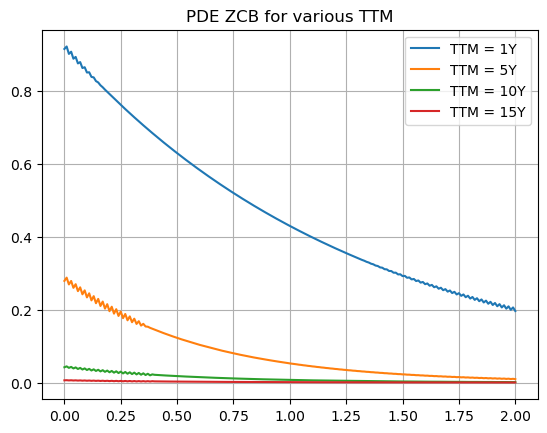

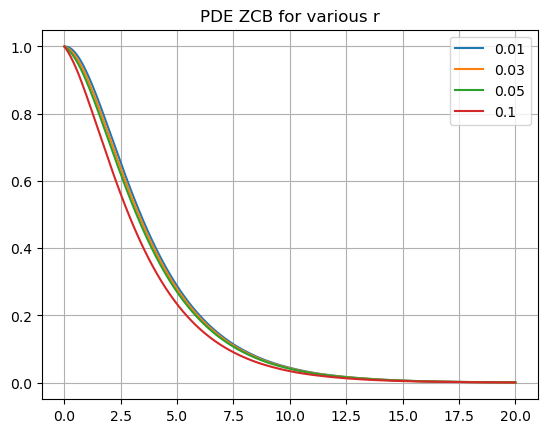

In [19]:
####################################################
# discretize ZcB value for r 
B = np.full((N, M), np.nan)
B[0, :] = zcb_mc[r_min].values
B[N-1, :] = zcb_mc[r_max].values

# intial condition (t=0 <=> expiry)
B0 = np.ones(N)
#B0[0] = zcb_mc[r_min].values
#B0[N] = zcb_mc[r_max].values

# create linear equations matrix 
A = np.zeros((N, N))

# case j=0
A[0, 0] = 1 + a*dt/dr # alpha
A[0, 1] = -a*dt/dr # beta

# for all lines between first and last lines 
for j in j_L[1:-1]:
    a_j = 0.5 * a * dt/dr - b*dt*0.5*(j-1) - sig**2 *dt/dr*(j-1)
    b_j = 1 + dr*(j-1)*dt + sig**2*dt/dr*(j-1)
    c_j = b*dt*0.5*(j-1) - a*dt*0.5/dr - sig**2 * dt*0.5/dr*(j-1)
    A[j, j-1] = a_j
    A[j, j] = b_j
    A[j, j+1] = c_j


####################################################
# Fill in B starting from init condition B0
B[:, 0] = B0
#B[-1, :]=0

A_mid = A[1:-1, 1:-1]
A_mid_inv = np.linalg.inv(A_mid)
for i in i_L[1:]:
    # A * B1 = B0 => solve for B1
    Bi = B[1:-1, i-1]
    Biplus1_first = B[0, i]
    Biplus1_last = B[-1, i]
    # Adjust B0 by subtracting the contributions from the known first and last values
    Bi_adjusted = Bi - A[1:-1, 0] * Biplus1_first - A[1:-1, -1] * Biplus1_last
    B_iplus1  = A_mid_inv.dot(Bi_adjusted)
    B[1:-1, i] = B_iplus1

zcb_pde = pd.DataFrame(B)
zcb_pde.columns = ["t_%i"%i for i in range(0, M)]
zcb_pde.index = ["r_%i"%j for j in range(0, N)]

## plot PDE for maturities 1Y, 5Y, 10Y, 15Y
T_values = [1, 5, 10, 15]
ti_ = ["t_%i"%(i*252) for i in T_values]
zcb_pde.loc[:, ti_]#.loc[:, _i]#[_i]#.plot(title = 'ZCB(T, r0) for various TTM')
zcb_pde_temp = zcb_pde.loc[:, ti_].set_index(r_j)
zcb_pde_temp.columns = ti_ = ["TTM = %iY"%(i) for i in T_values]
zcb_pde_temp.plot(grid=True)
plt.title('PDE ZCB for various TTM')
plt.show()

# plot across
#j_ = j_L[np.isin([0.01, 0.02, 0.1], np.array(r_j))]
#plt.plot(t_i, B[j_ , :].T.flatten())
j_ = j_L[np.isin(np.array(r_j), r_mc[1:-1])]
zcb_pde_temp2 = zcb_pde.iloc[j_, :]
zcb_pde_temp2.index = r_mc[1:-1]
zcb_pde_temp2.columns = t_i
zcb_pde_temp2.T.plot(grid = True, title= "PDE ZCB for various r")
plt.show()



# error plot MC vs PDE discretization
#plt.plot(t_i, np.array(zcb_i)- B[j_ , :].T.flatten())


#B_temp  = B[j_ , :].T

### 3) compare PDE vs Monte Carlo results

############################################################
r0 :  0.01
############################################################


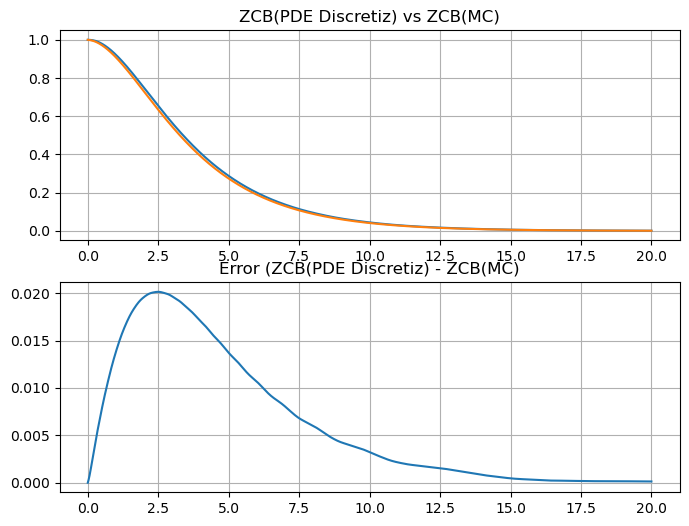

############################################################
r0 :  0.03
############################################################


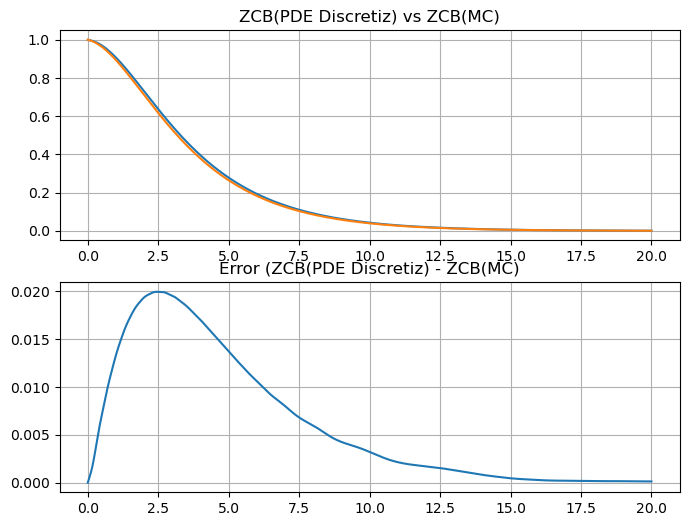

############################################################
r0 :  0.05
############################################################


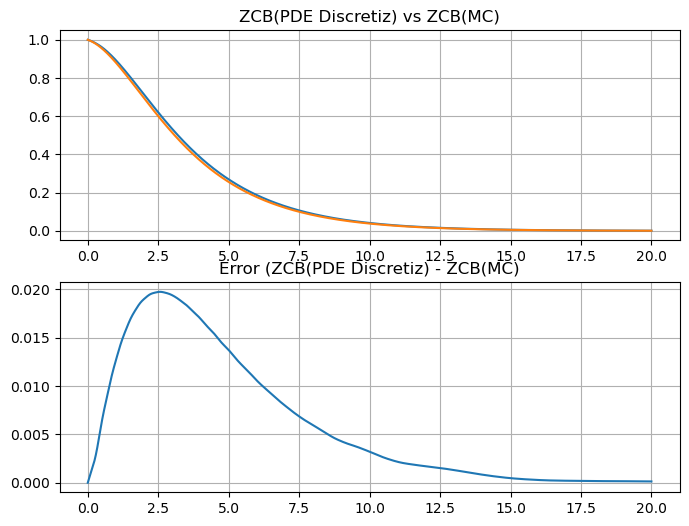

############################################################
r0 :  0.1
############################################################


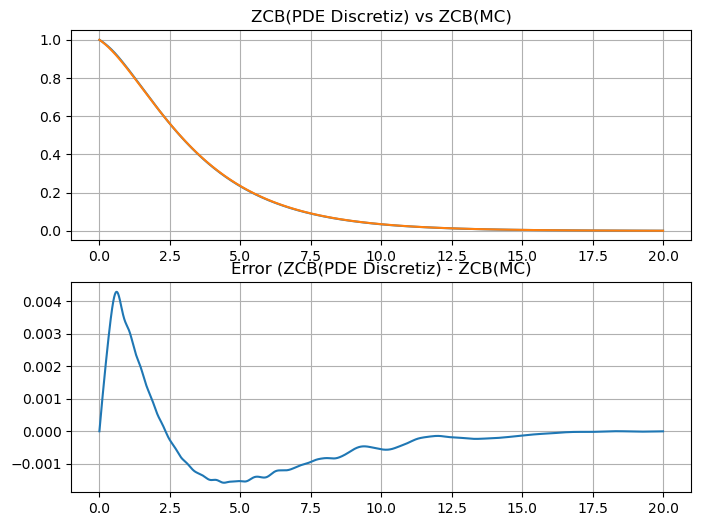

In [22]:
# match index of mc vs pde
zcb_mc.index = zcb_pde_temp2.T.index 

for r in r_mc[1:-1]:
    print("############################################################")
    print("r0 : ", r)
    print("############################################################")
    fig, ax = plt.subplots(2, 1, figsize=(8, 6)) 
    zcb_pde_temp2.T[r].plot(grid=True, ax=ax[0], title= 'ZCB(PDE Discretiz) vs ZCB(MC)')
    zcb_mc.loc[:, r].plot(grid=True, ax=ax[0])
    error = zcb_pde_temp2.T[r] - zcb_mc.loc[:, r]
    error.plot(grid=True, ax=ax[1], title= 'Error (ZCB(PDE Discretiz) - ZCB(MC)')
    plt.show()
